# Import OSMNX and stuff

### OSRM notes:
```
cd ~/Documents/work/osrm/
docker run -t -v $(pwd):/data osrm/osrm-backend osrm-extract -p /opt/car.lua /data/new-hampshire-latest.osm.pbf
docker run -t -v $(pwd):/data osrm/osrm-backend osrm-partition /data/new-hampshire-latest.osrm
docker run -t -v $(pwd):/data osrm/osrm-backend osrm-customize /data/new-hampshire-latest.osrm
docker run -t -i -p 5000:5000 -v $(pwd):/data osrm/osrm-backend osrm-routed --algorithm mld /data/new-hampshire-latest.osrm
```

In [1]:
import osmnx as ox

In [2]:
_,origin_point = ox.graph_from_address('2700 Broadway, New York City, New York', simplify=False, clean_periphery=False,
                                     retain_all=True, distance=50, network_type='all', return_coords=True)
home = ox.graph_from_place('Manhattan Island, New York City, New York, USA', network_type='drive')

## How's it look?

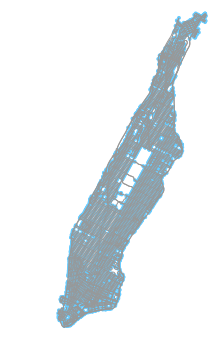

/Users/octavisemonin/anaconda3/envs/geo/lib/python3.6/site-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


In [3]:
G = home.copy()
# G = nyc.copy()
# G = sf.copy()

center_node = ox.get_nearest_node(G, origin_point)
G = ox.project_graph(G)
fig, ax = ox.plot_graph(G)
ax.scatter([G.nodes[center_node]['x']], [G.nodes[center_node]['y']],
           color='red', s=150, zorder=10)
fig.show()

### COOOOOOL.

### initialize edge traffic to 1, source node traffic to 1:

In [4]:
for u, v, k, data in G.edges(data=True, keys=True):
    data['through_traffic'] = 1
    
for node, data in G.nodes(data=True):
    data['source_traffic'] = 1
    data['transit_time'] = 0 # np.nan

## This does routing

In [5]:
import requests
import time

In [59]:
def chunks(l, n):
    """Yield successive n-sized chunks from l."""
    for i in range(0, len(l), n):
        yield l[i:i + n]
        
end = '%s,%s' % (origin_point[1],origin_point[0])
starts = ['%s,%s' % (data['lon'],data['lat']) for n,data in G.node(data=True)]
times = []

# the table service seems limited in number
for chunk in chunks(starts, 350):
    chunk = ';'.join(chunk)
    query = 'http://router.project-osrm.org/table/v1/driving/%s;%s?sources=0' % (end,chunk)
    r = requests.get(query)
    times = times + r.json()['durations'][0][1:]

for n,node in enumerate(G.node):
    G.nodes[node]['transit_time'] = times[n]

In [61]:
from tqdm import tqdm
import networkx as nx

# Show it!

In [62]:
import pickle
import numpy as np
import matplotlib.cm as cm
% matplotlib inline

In [63]:
# edge_intensity = np.log10(np.array([data['through_traffic'] for u, v, data in G.edges(data=True)]))
# edge_intensity = np.log2(np.array([data['through_traffic'] for u, v, data in G.edges(data=True)]))
# edge_widths = (edge_intensity / edge_intensity.max() ) * 3 #+ 1
edge_widths = 1

# to color by transit count:
# edge_intensity = (edge_intensity / edge_intensity.max() ) * .95 + .05
# edge_intensity = (edge_intensity*255).astype(np.uint8)

# to color by transit time:
edge_intensity = np.array([G.nodes[u]['transit_time'] + G.nodes[v]['transit_time'] for u,v in G.edges()])
edge_intensity = (edge_intensity / edge_intensity.max() ) * .95 + .05
edge_intensity = (255 - edge_intensity*255).astype(np.uint8)

cmap = cm.get_cmap(name='magma')
edge_colors = cmap(edge_intensity)

# node_colors = cmap(node_intensity)

/Users/octavisemonin/anaconda3/envs/geo/lib/python3.6/site-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


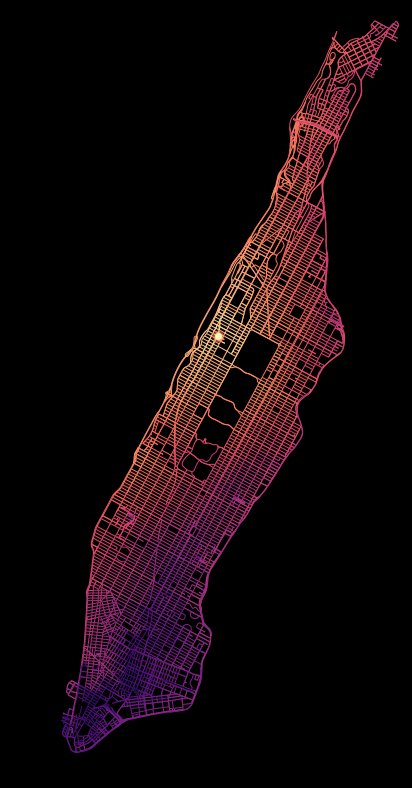

In [64]:
fig, ax = ox.plot_graph(G, edge_color=edge_colors, edge_linewidth=edge_widths, equal_aspect=True, node_size=0, 
                        save=True, fig_height=14, fig_width=16, use_geom=True , close=False, show=False,  bgcolor='k')

ax.scatter([G.nodes[center_node]['x']], [G.nodes[center_node]['y']],
           color='red', s=150, zorder=10, alpha=.25)
ax.scatter([G.nodes[center_node]['x']], [G.nodes[center_node]['y']],
           color='pink', s=100, zorder=10, alpha=.3)
ax.scatter([G.nodes[center_node]['x']], [G.nodes[center_node]['y']],
           color='yellow', s=50, zorder=10, alpha=.6)
ax.scatter([G.nodes[center_node]['x']], [G.nodes[center_node]['y']],
           color='white', s=30, zorder=10, alpha=.75)

# fig.savefig('nyc-bike.png', facecolor=fig.get_facecolor(), dpi=300)
fig.show()

# Contour map

In [65]:
max_x,max_y = -np.Inf,-np.Inf
min_x,min_y = np.Inf, np.Inf

for node,data in G.nodes(data=True):
    x = data['lon']
    y = data['lat']
    
    min_x = x if x<min_x else min_x
    min_y = y if y<min_y else min_y
    max_x = x if x>max_x else max_x
    max_y = y if y>max_y else max_y

X = np.arange(min_x, max_x, 0.001)
Y = np.arange(min_y, max_y, 0.001)

topo = np.ones(shape=(len(Y),len(X)))

# for j,x in enumerate(tqdm(X)):
#     for i,y in enumerate(Y):
#         nearest_node,distance = ox.get_nearest_node(G, (y,x), method='euclidean', return_dist=True)
#         topo[i,j] = G.nodes[nearest_node]['transit_time'] if distance<200 else 0
#         topo_plus_feet[i,j] = G.nodes[nearest_node]['transit_time'] + distance if distance<500 else 0

In [66]:
topo.shape

(172, 107)

In [67]:
X,Y = np.meshgrid(X,Y)

In [68]:
np.array((X.ravel(),Y.ravel())).shape

(2, 18404)

In [113]:
starts.shape

(2, 18404)

In [118]:
starts = np.array((X.ravel(),Y.ravel()))
pairs = ['%s,%s' % (x,y) for x,y in chunk.transpose()]
times = []

# the table service seems limited in number
for chunk in chunks(pairs, 350):
    start_string = ';'.join(chunk)
    query = 'http://router.project-osrm.org/table/v1/driving/%s;%s?sources=0' % (end,start_string)
    r = requests.get(query)
    times = times + r.json()['durations'][0][1:]

In [120]:
temp = np.array(times).reshape(topo.shape)

In [121]:
temp.shape

(172, 107)

In [122]:
import matplotlib.pyplot as plt

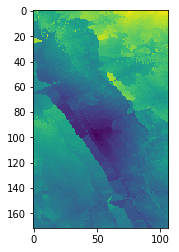

In [124]:
plt.imshow(temp)

<a list of 7 text.Text objects>

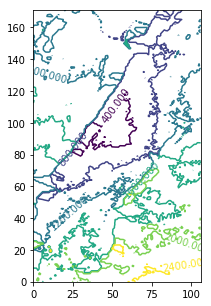

In [127]:
plt.figure(figsize=(3,5))
CS = plt.contour(temp)
plt.clabel(CS, inline=1, fontsize=10)